In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import copy
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/content/drive/MyDrive/induction_motor')
import modules,scaler


In [2]:
normal_data = pd.read_csv('/content/drive/MyDrive/induction_motor/combined_data.csv')

In [3]:
train_scaler = scaler.Scaler()
train_scaler.fit_unlabelled_data(normal_data)

using MinMaxScaler()


In [4]:
train_scaled = train_scaler.transform(normal_data)
train_scaled.shape

(3170000, 3)

In [5]:
train = train_scaled[:2530000]
test = train_scaled[2530000:]

In [6]:
train.shape,test.shape

((2530000, 3), (640000, 3))

In [7]:
#As required for LSTM networks, we require to reshape an input data into
#  n_samples x timesteps x n_features. 
timesteps = 25  #timestep choice 1 , since sampling 10KHz and Fundamental 50Hz (assumption) 20 would be low and high sampling freq needs it to be a bit more. So need to do train and error. It depends on the length of the signal you want to capture.
n_features = 3
# To reshape the train array into an array of shape (n_samples, timesteps, n_features), you need to ensure that the total number of elements in the array is a multiple of timesteps.
re_train = train.reshape(-1, timesteps, n_features)
re_test = test.reshape(-1, timesteps, n_features)


In [8]:
re_train.shape

(101200, 25, 3)

In [9]:
# possible timesteps
ts = [i for i in range(20,100) if train.shape[0] % i == 0]
ts

[20, 22, 23, 25, 40, 44, 46, 50, 55, 80, 88, 92]

In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

https://www.youtube.com/watch?v=6S2v7G-OupA for reference

In [11]:
# simple model
# model = Sequential()

# model.add(LSTM(128, activation='tanh', input_shape=(re_train.shape[1], re_train.shape[2]), return_sequences=True))
# model.add(LSTM(64, activation='tanh', return_sequences=False))
# model.add(RepeatVector(re_train.shape[1]))
# model.add(LSTM(64, activation='tanh', return_sequences=True))
# model.add(LSTM(128, activation='tanh', return_sequences=True))
# model.add(TimeDistributed(Dense(re_train.shape[2])))

# model.compile(optimizer='adam', loss='mse')
# model.summary()

In [12]:
class LSTMAutoEncoder(Model):
    def __init__(self,shape, activation='tanh'):
        super(LSTMAutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            # using tanh as default instead of relu else returns warning lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU
            # https://stackoverflow.com/questions/68844792/lstm-will-not-use-cudnn-kernels-since-it-doesnt-meet-the-criteria-it-will-use
            tf.keras.layers.LSTM(64, activation=activation,input_shape=(shape[1],shape[2]) , return_sequences=True), #when the next layer is an LSTM too. The next layer needs a sequence of data. 
            tf.keras.layers.LSTM(32, activation=activation, return_sequences=True),
            tf.keras.layers.LSTM(16, activation=activation, return_sequences=False),
            # tf.keras.layers.Dropout(rate=0.2)
            tf.keras.layers.RepeatVector(shape[1])])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.LSTM(16, activation=activation, return_sequences=True),
            tf.keras.layers.LSTM(32, activation=activation, return_sequences=True),
            tf.keras.layers.LSTM(64, activation=activation, return_sequences=True),
            # tf.keras.layers.Dropout(rate=0.2)
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(shape[2]))])
# TimeDistri layer Takes in the number dimension of matrix to produce. This vector is multiplied to the input matrix and to get the desired output. 
# In our case, if previous layer (2nd last layer, outputs 
# n_samples * 25 (timesteps) * 128 (features generated in hidden layer) and we want our final output as n_samples * 25 * 3, The TimeDistributed layer would need to create a matrix of dimensions 128 * 3, which are weights.
# such that (25 * 128)  X (128 * 3) = (25 * 3)


    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
model= LSTMAutoEncoder(re_train.shape)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',     #stop if val_loss does not improve for more than 2 epochs
                                                    patience=4,
                                                    mode='min')  #check for min of val_loss, if accuracy then it should be max, 'auto' does it automatically

model.compile(optimizer='adam', loss='mae')  


In this specific example, the same train and test data are used twice because it is an autoencoder model. The goal of the model is to reconstruct the input sequence by training on the same input sequence. So, during the training phase, the model is trained on the training set, and then the performance is evaluated on the same training set as well as the separate validation set (which is the same as the test set in this case).

In [14]:
len(re_train)-1200    #for convenience

100000

In [17]:
len(re_test), len(re_train)

(25600, 101200)

In [18]:
from tqdm import tqdm

for i in tqdm(range(0, len(re_train)-1200, 10000)):
    test_batch = re_test[(i % len(re_test)): (i % len(re_test)) + 10000]
    history = model.fit(re_train[i:i+10000], re_train[i:i+10000],
                        epochs=100,
                        batch_size=128,
                        validation_data=(test_batch, test_batch),
                        shuffle=False,
                        callbacks=[early_stopping],
                        verbose=0)


100%|██████████| 10/10 [05:25<00:00, 32.53s/it]


In [19]:
 model.summary()

Model: "lstm_auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 25, 16)            32960     
                                                                 
 sequential_1 (Sequential)   (None, 25, 3)             33411     
                                                                 
Total params: 66,371
Trainable params: 66,371
Non-trainable params: 0
_________________________________________________________________


trying out the predictions

In [20]:
pred = model.predict(re_train[0:1000])

32/32 [==============================] - 3s 9ms/step


In [21]:
pred.shape

(1000, 25, 3)

In [22]:
re_pred = pred.reshape(pred.shape[0] * pred.shape[1], pred.shape[2])

In [23]:
re_pred.shape

(25000, 3)

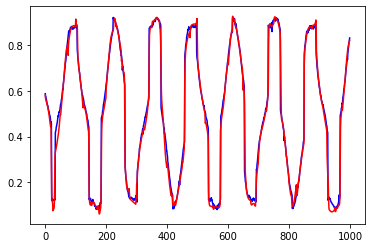

In [24]:
plt.plot(train[0:1000,0:1],'b')
plt.plot(re_pred[0:1000,0:1],'r')

test the overall reconstruction error

In [25]:
pred = model.predict(re_train)
re_pred = pred.reshape(pred.shape[0] * pred.shape[1], pred.shape[2])
train_loss = tf.keras.losses.mae(re_pred, train)

3163/3163 [==============================] - 21s 7ms/step


<Axes: ylabel='Density'>

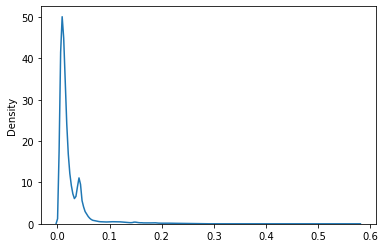

In [26]:
import seaborn as sns
sns.kdeplot(train_loss, bw_adjust= 0.5)

In [27]:
threshold = np.mean(train_loss) + 4*np.std(train_loss)

In [28]:
np.sum(train_loss > threshold)

39883

In [29]:
indices = np.where(tf.math.less(train_loss, threshold) == False)[0]

In [30]:
file_size = 10000
num_files = len(train_scaled) // file_size
ano_dict = {}
# Create histogram of indices based on file number
hist, bin_edges = np.histogram(indices, bins=num_files, range=(0, len(train_scaled)))
file_indices = np.digitize(indices, bin_edges[:-1])

# Count number of anomalies per file
file_counts = {}
for i in range(1, num_files+1):
    file_counts[i] = np.count_nonzero(file_indices == i)

# Sort files by number of anomalies (in descending order)
sorted_files = sorted(file_counts.items(), key=lambda x: x[1], reverse=True)

# Print results
for file_num, count in sorted_files:
    ano_dict[file_num] = count
    # print(f"File {file_num}: {count} anomalies")

In [31]:
ano_dict

{243: 3773,
 236: 247,
 240: 246,
 231: 239,
 235: 237,
 233: 232,
 230: 219,
 111: 207,
 232: 206,
 220: 199,
 65: 196,
 17: 190,
 121: 189,
 97: 187,
 179: 186,
 76: 185,
 225: 184,
 98: 183,
 92: 181,
 227: 180,
 80: 179,
 77: 176,
 169: 176,
 129: 174,
 174: 174,
 88: 173,
 137: 172,
 91: 171,
 103: 171,
 23: 170,
 219: 170,
 241: 169,
 253: 169,
 101: 168,
 221: 168,
 16: 167,
 94: 167,
 117: 166,
 185: 165,
 218: 165,
 149: 164,
 242: 164,
 125: 162,
 138: 162,
 229: 161,
 105: 160,
 147: 160,
 202: 160,
 72: 158,
 123: 158,
 164: 158,
 211: 158,
 118: 157,
 14: 156,
 22: 156,
 157: 156,
 159: 156,
 251: 156,
 47: 155,
 100: 153,
 126: 153,
 141: 153,
 193: 153,
 81: 152,
 161: 152,
 190: 152,
 99: 151,
 115: 151,
 198: 151,
 210: 151,
 2: 150,
 30: 150,
 96: 150,
 184: 150,
 21: 149,
 36: 149,
 213: 149,
 246: 149,
 171: 148,
 182: 148,
 191: 148,
 3: 147,
 150: 147,
 188: 147,
 201: 147,
 212: 147,
 215: 147,
 178: 146,
 183: 146,
 203: 146,
 226: 146,
 252: 146,
 89: 145,
 127

In [32]:
def fil(pair):
  key,value = pair
  if value >= 150:
    return True
  else:
    return False

In [33]:
dict(filter(fil,ano_dict.items()))

{243: 3773,
 236: 247,
 240: 246,
 231: 239,
 235: 237,
 233: 232,
 230: 219,
 111: 207,
 232: 206,
 220: 199,
 65: 196,
 17: 190,
 121: 189,
 97: 187,
 179: 186,
 76: 185,
 225: 184,
 98: 183,
 92: 181,
 227: 180,
 80: 179,
 77: 176,
 169: 176,
 129: 174,
 174: 174,
 88: 173,
 137: 172,
 91: 171,
 103: 171,
 23: 170,
 219: 170,
 241: 169,
 253: 169,
 101: 168,
 221: 168,
 16: 167,
 94: 167,
 117: 166,
 185: 165,
 218: 165,
 149: 164,
 242: 164,
 125: 162,
 138: 162,
 229: 161,
 105: 160,
 147: 160,
 202: 160,
 72: 158,
 123: 158,
 164: 158,
 211: 158,
 118: 157,
 14: 156,
 22: 156,
 157: 156,
 159: 156,
 251: 156,
 47: 155,
 100: 153,
 126: 153,
 141: 153,
 193: 153,
 81: 152,
 161: 152,
 190: 152,
 99: 151,
 115: 151,
 198: 151,
 210: 151,
 2: 150,
 30: 150,
 96: 150,
 184: 150}

This approach seems to have identified less anomalies than the Feed Forward approach Which means that this is much more suitable and gives far less false positives

Testing on artificial Anomalous Data

In [34]:
anomalous_data = pd.read_csv('/content/drive/MyDrive/induction_motor/combined_anomalous.csv')
anomalous_scaled = train_scaler.transform(anomalous_data)
anomalous_scaled.shape

(3170000, 3)

In [35]:
re_anomalous = anomalous_scaled.reshape(-1, timesteps, n_features)

In [36]:
ano_pred = model.predict(re_anomalous)
re_pred_ano = ano_pred.reshape(ano_pred.shape[0] * ano_pred.shape[1], ano_pred.shape[2])

3963/3963 [==============================] - 27s 7ms/step


In [37]:
np.mean(tf.keras.losses.mae(re_pred_ano, anomalous_scaled))

0.3005456875619685

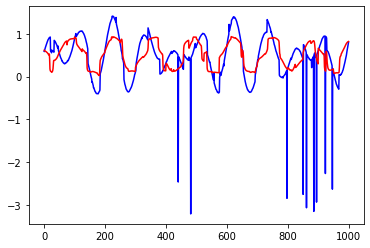

In [38]:
plt.plot(anomalous_scaled[0:1000,0:1],'b')
plt.plot(re_pred_ano[0:1000,0:1],'r')